The goal of this notebook is to code a decision tree classifier/regressor that can be used with the following API:

```Python
df = pd.read_csv("data.csv")

train_df, test_df = train_test_split(df, test_size=0.2)
tree = decision_tree_algorithm(train_df, ml_task="regression")
accuracy = calculate_accuracy(test_df, tree)
```

The algorithm that is going to be implemented looks like this:

<img src="https://raw.githubusercontent.com/SebastianMantey/Decision-Tree-from-Scratch/master/images/decision_tree_algorithm_2.png" width="350">

# Import Statements

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
from pprint import pprint

In [2]:
%matplotlib inline
sns.set_style("darkgrid")

# Load and Prepare Data

#### Format of the data
- the last column of the data frame must contain the label and it must also be called "label"
- there should be no missing values in the data frame

In [3]:
df = pd.read_csv("../data/Bike.csv", parse_dates=["dteday"])
df = df.drop(["instant", "casual", "registered"], axis=1)
df = df.rename({"dteday": "date"}, axis=1)

In [4]:
df.head()

,date,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [5]:
date_column = df.date

df["day_of_year"] = date_column.dt.dayofyear
df["day_of_month"] = date_column.dt.day

df["quarter"] = date_column.dt.quarter
df["week"] = date_column.dt.week

df["is_month_end"] = date_column.dt.is_month_end
df["is_month_start"] = date_column.dt.is_month_start
df["is_quarter_end"] = date_column.dt.is_quarter_end
df["is_quarter_start"] = date_column.dt.is_quarter_start
df["is_year_end"] = date_column.dt.is_year_end
df["is_year_start"] = date_column.dt.is_year_start

df = df.set_index("date")

In [6]:
df["label"] = df.cnt
df = df.drop("cnt", axis=1)

In [7]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,day_of_month,quarter,week,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,label
date,,,,,,,,,,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,...,1,1,52,False,True,False,True,False,True,985
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,...,2,1,52,False,False,False,False,False,False,801
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,...,3,1,1,False,False,False,False,False,False,1349
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,...,4,1,1,False,False,False,False,False,False,1562
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,...,5,1,1,False,False,False,False,False,False,1600


# Train-Val-Test-Split

In [8]:
train_df = df.iloc[:-122]
val_df = df.iloc[-122:-61]  # Sep and Oct of 2012
test_df = df.iloc[-61:]     # Nov and Dec of 2012

# Helper Functions

The helper functions operate on a NumPy 2d-array. Therefore, let’s create a variable called “data” to see what we will be working with.

In [9]:
data = train_df.values[:5]
data

array([[1, 0, 1, 0, 6, 0, 2, 0.344167, 0.363625, 0.805833, 0.160446, 1,
        1, 1, 52, False, True, False, True, False, True, 985],
       [1, 0, 1, 0, 0, 0, 2, 0.363478, 0.35373899999999997, 0.696087,
        0.24853899999999998, 2, 2, 1, 52, False, False, False, False,
        False, False, 801],
       [1, 0, 1, 0, 1, 1, 1, 0.196364, 0.189405, 0.43727299999999997,
        0.248309, 3, 3, 1, 1, False, False, False, False, False, False,
        1349],
       [1, 0, 1, 0, 2, 1, 1, 0.2, 0.21212199999999998, 0.590435,
        0.160296, 4, 4, 1, 1, False, False, False, False, False, False,
        1562],
       [1, 0, 1, 0, 3, 1, 1, 0.22695700000000002, 0.22926999999999997,
        0.436957, 0.1869, 5, 5, 1, 1, False, False, False, False, False,
        False, 1600]], dtype=object)

### Data pure?

In [10]:
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

### Create Leaf

In [11]:
def create_leaf(data, ml_task):
    
    label_column = data[:, -1]
    if ml_task == "regression":
        leaf = np.mean(label_column)
        
    # classfication    
    else:
        unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)
        index = counts_unique_classes.argmax()
        leaf = unique_classes[index]
    
    return leaf

### Potential splits?

In [12]:
def get_potential_splits(data):
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):          # excluding the last column which is the label
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits

### Split Data

In [13]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

### Determine Best Split

In [14]:
def calculate_mse(data):
    actual_values = data[:, -1]
    if len(actual_values) == 0:   # empty data
        mse = 0
        
    else:
        prediction = np.mean(actual_values)
        mse = np.mean((actual_values - prediction) **2)
    
    return mse

In [15]:
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [16]:
def calculate_overall_metric(data_below, data_above, metric_function):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_metric =  (p_data_below * metric_function(data_below) 
                     + p_data_above * metric_function(data_above))
    
    return overall_metric

In [17]:
def determine_best_split(data, potential_splits, ml_task):
    
    first_iteration = True
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            
            if ml_task == "regression":
                current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_mse)
            
            # classification
            else:
                current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_entropy)

            if first_iteration or current_overall_metric <= best_overall_metric:
                first_iteration = False
                
                best_overall_metric = current_overall_metric
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

# Decision Tree Algorithm

### Representation of the Decision Tree

In [18]:
sub_tree = {"question": ["yes_answer", 
                         "no_answer"]}

In [19]:
example_tree = {"petal_width <= 0.8": ["Iris-setosa", 
                                      {"petal_width <= 1.65": [{"petal_length <= 4.9": ["Iris-versicolor", 
                                                                                        "Iris-virginica"]}, 
                                                                "Iris-virginica"]}]}

### Determine Type of Feature

In [20]:
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

### Algorithm

In [21]:
def decision_tree_algorithm(df, ml_task, counter=0, min_samples=2, max_depth=5):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        leaf = create_leaf(data, ml_task)
        return leaf

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits, ml_task)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            leaf = create_leaf(data, ml_task)
            return leaf
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, ml_task, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, ml_task, counter, min_samples, max_depth)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [22]:
tree = decision_tree_algorithm(train_df, ml_task="regression", max_depth=3)
pprint(tree)

{'temp <= 0.43083299999999997': [{'yr = 1': [{'atemp <= 0.282821': [2811.90625,
                                                                    4139.282608695652]},
                                             {'season = 4': [3364.734693877551,
                                                             1711.138888888889]}]},
                                 {'yr = 1': [{'hum <= 0.768333': [6631.973154362416,
                                                                  5131.35294117647]},
                                             {'weathersit = 3': [2320.5,
                                                                 4374.32]}]}]}


# Prediction

In [23]:
sub_tree

{'question': ['yes_answer', 'no_answer']}

In [24]:
example = test_df.iloc[0]
example

season                     4
yr                         1
mnth                      11
holiday                    0
weekday                    4
workingday                 1
weathersit                 2
temp                0.365833
atemp               0.369942
hum                 0.581667
windspeed           0.157346
day_of_year              306
day_of_month               1
quarter                    4
week                      44
is_month_end           False
is_month_start          True
is_quarter_end         False
is_quarter_start       False
is_year_end            False
is_year_start          False
label                   5986
Name: 2012-11-01 00:00:00, dtype: object

In [25]:
def predict_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

In [26]:
predict_example(example, tree)

4139.282608695652

# Hyperparameter Tuning

In [27]:
def calculate_r_squared(df, tree):    
    labels = df.label
    mean = labels.mean()
    predictions = df.apply(predict_example, args=(tree,), axis=1)

    ss_res = sum((labels - predictions) ** 2)
    ss_tot = sum((labels - mean) ** 2)
    r_squared = 1 - ss_res / ss_tot
    
    return r_squared

The following cell takes some time to run!!!

In [28]:
grid_search = {"max_depth": [], "min_samples": [], "r_squared_train": [], "r_squared_val": []}
for max_depth in range(1, 7):
    for min_samples in range(5, 20, 5):
        tree = decision_tree_algorithm(train_df, ml_task="regression", max_depth=max_depth, min_samples=min_samples)
        
        r_squared_train = calculate_r_squared(train_df, tree)
        r_squared_val = calculate_r_squared(val_df, tree)
        
        grid_search["max_depth"].append(max_depth)
        grid_search["min_samples"].append(min_samples)
        grid_search["r_squared_train"].append(r_squared_train)
        grid_search["r_squared_val"].append(r_squared_val)
        
    print(f"Progress: Iteration {max_depth}/6")
        
grid_search = pd.DataFrame(grid_search)
grid_search.sort_values("r_squared_val", ascending=False).head()

Progress: Iteration 1/6
Progress: Iteration 2/6
Progress: Iteration 3/6
Progress: Iteration 4/6
Progress: Iteration 5/6
Progress: Iteration 6/6


,max_depth,min_samples,r_squared_train,r_squared_val
17,6,15,0.908506,0.353872
14,5,15,0.889445,0.353114
12,5,5,0.898242,0.350148
13,5,10,0.896774,0.342261
16,6,10,0.922621,0.305817


# Visualization

In [29]:
best_max_depth = 6
best_min_samples = 15

tree = decision_tree_algorithm(train_df, ml_task="regression", max_depth=best_max_depth, min_samples=best_min_samples)
calculate_r_squared(test_df, tree)

0.3731432532410548

In [30]:
def create_plot(df, tree, title):    
    predictions = df.apply(predict_example, args=(tree,), axis=1)
    actual = df.label
    plot_df = pd.DataFrame({"actual": actual, "predictions": predictions})
    
    plot_df.plot(figsize=(18, 5), title=title)
    
    return

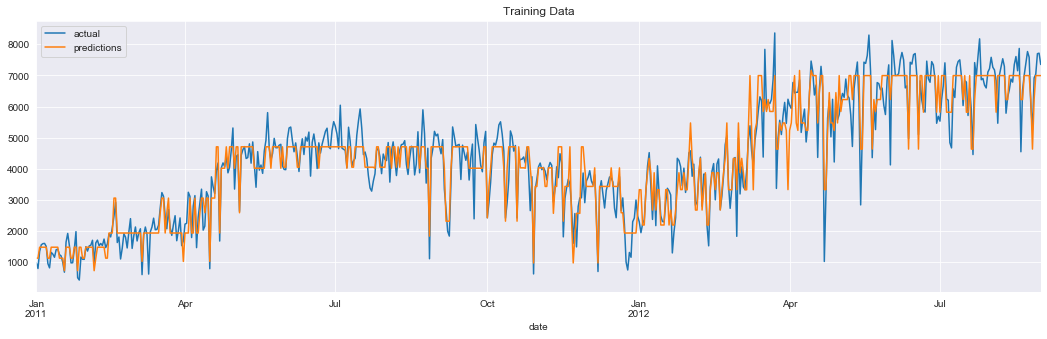

In [31]:
create_plot(train_df, tree, title="Training Data")

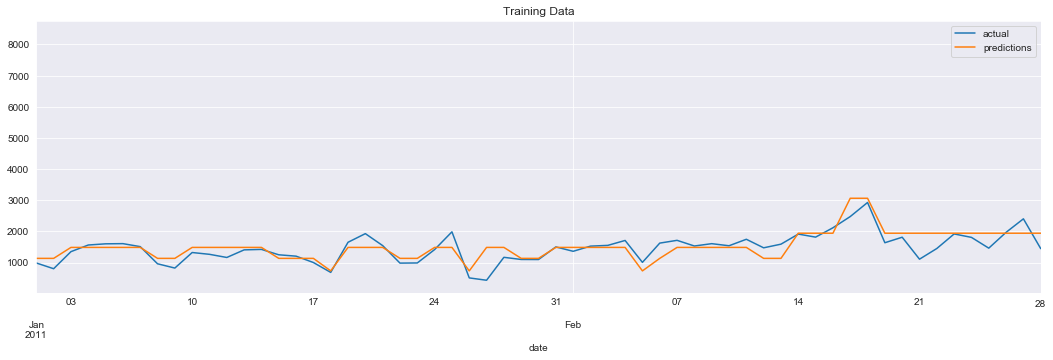

In [32]:
create_plot(train_df, tree, title="Training Data")
plt.xlim(pd.to_datetime("2011-01-01"), pd.to_datetime("2011-02-28"));

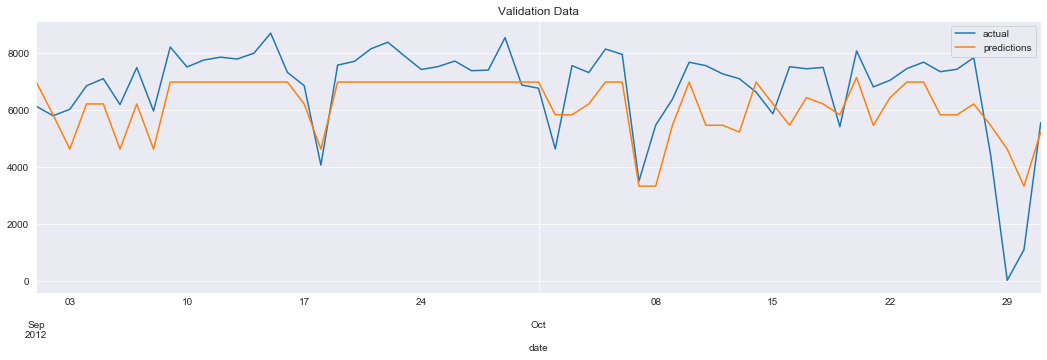

In [33]:
create_plot(val_df, tree, title="Validation Data")

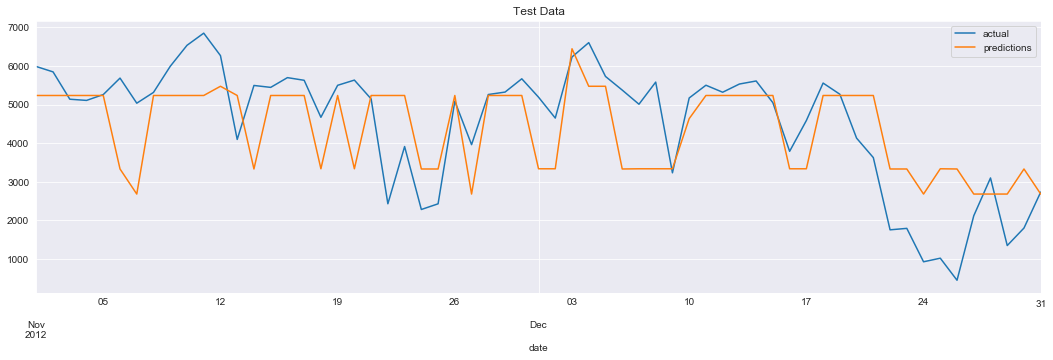

In [34]:
create_plot(test_df, tree, title="Test Data")

# Classification Task

In [35]:
df = pd.read_csv("../data/Iris.csv")
df = df.drop("Id", axis=1)
df = df.rename(columns={"species": "label"})

In [36]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [37]:
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [38]:
random.seed(0)
train_df, test_df = train_test_split(df, test_size=20)

In [39]:
tree = decision_tree_algorithm(train_df, ml_task="classification", max_depth=3)
pprint(tree)

{'petal_width <= 0.6': ['Iris-setosa',
                        {'petal_width <= 1.6': [{'petal_length <= 4.9': ['Iris-versicolor',
                                                                         'Iris-virginica']},
                                                'Iris-virginica']}]}


In [40]:
def calculate_accuracy(df, tree):

    df["classification"] = df.apply(predict_example, args=(tree,), axis=1)
    df["classification_correct"] = df["classification"] == df["label"]
    
    accuracy = df["classification_correct"].mean()
    
    return accuracy

In [41]:
accuracy = calculate_accuracy(test_df, tree)
accuracy

0.95